In [1]:
import numpy as np
import os, sys
import yaml
import astropy.io.ascii as ascii
%pylab inline
from astropy.io import fits
from astropy.table import Table,join
import astropy as ap
from multiprocessing import Pool,Value
from functools import partial
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
from scipy import ndimage
from matplotlib.patches import Ellipse, Circle
from sklearn import linear_model


Populating the interactive namespace from numpy and matplotlib


In [2]:
source_id = np.loadtxt('source_id.txt',dtype=str)
z_table = []
z_2d = []
z_2d_up1 = []
z_2d_low1 = []
for id_name in source_id:
    z = Table.read('output_10pix_sm/ELD_oh12_2d_id%s.txt'%id_name,format='ascii.commented_header')
    z_table.append(z)
    z_2d.append(z['me'].copy().reshape(20,20))
    z_2d_up1.append(z['me_up1sig'].copy().reshape(20,20))
    z_2d_low1.append(z['me_low1sig'].copy().reshape(20,20))

In [3]:
ra = np.array([])
dec = np.array([])
for i in source_id:
    info = Table.read('../grismspec_boss1244_210627/boss1244_DR210308_%s.row.fits'%i,hdu=1)
    ra = np.append(ra,asarray(info['ra']))
    dec = np.append(dec,asarray(info['dec']))

In [4]:
w = 10

j1244_cut = fits.open('../Photometry/j1244_cut.fits')
j1244_cut_img = j1244_cut[0].data
j1244_cut.close()

h1244_cut = fits.open('../Photometry/h1244_cut.fits')
h1244_cut_img = h1244_cut[0].data
h1244_cut.close()

w_j_cut = WCS(j1244_cut[0].header)
j1244_cut.close()

c = SkyCoord(ra=ra*u.degree, dec=dec*u.degree)

j_x = w_j_cut.world_to_pixel(c)[0]
j_y = w_j_cut.world_to_pixel(c)[1]

h1244_wht = fits.open('../Photometry/h1244_wht_cut.fits')
h1244_wht_img = h1244_wht[0].data

seg_all = fits.open('/home/zihao/win/study/astrophysics/sextractor-2.25.0/tests/h1244/h1244.seg.fits')
seg_all = seg_all[0].data

s_pix = w
h_stamp = []
h_wht_stamp = []
seg_stamp = []
for i in range(len(source_id)):

    j_cutx = round(j_x[i])
    j_cuty = round(j_y[i])
#     j_stamp.append(j1244_cut_img[j_cuty-s_pix:j_cuty+s_pix,j_cutx-s_pix:j_cutx+s_pix])
    h_stamp.append(h1244_cut_img[j_cuty-s_pix:j_cuty+s_pix,j_cutx-s_pix:j_cutx+s_pix])
    h_wht_stamp.append(h1244_wht_img[j_cuty-s_pix:j_cuty+s_pix,j_cutx-s_pix:j_cutx+s_pix])
    seg_stamp.append(seg_all[j_cuty-s_pix:j_cuty+s_pix,j_cutx-s_pix:j_cutx+s_pix])

In [5]:
EL_data = []
for j,i in enumerate(source_id):

    info = Table.read('../grismspec_boss1244_210627/boss1244_DR210308_%s.row.fits'%i,hdu=1)
    ra1 = info['ra']
    dec1 = info['dec']
    hdu = fits.open('../grismspec_boss1244_210627/boss1244_DR210308_%s.full.fits'%i)
    sp_1d = Table.read('../grismspec_boss1244_210627/boss1244_DR210308_%s.1D.fits'%i,hdu=1)
    wave_1d = sp_1d['wave']
    flat = sp_1d['flat']
    Elines = {}
    
    seg = seg_stamp[j].astype(float)
    seg[seg!=seg[w,w]] = nan
    seg/=seg[w,w]
    for j in range(len(hdu)):
        try:
            header = hdu[j].header
            EXTVER = header['EXTVER']
            EXTNAME = header['EXTNAME']
            
            if EXTVER in ['OII','Hb','Hg','OIII'] and EXTNAME =='LINE':
                flat_idx = np.argmin(np.abs(wave_1d - hdu[j].header['WAVELEN']))
                EL_img = hdu[j].data[66-w:66+w,66-w:66+w]
                EL_img_sm = ndimage.gaussian_filter(EL_img,3.333/2.355)
                Elines['flux_'+EXTVER] = (seg*EL_img_sm)
                
            elif EXTVER in ['OII','Hb','Hg','OIII'] and EXTNAME =='LINEWHT':
                err_img = 1/(hdu[j].data[66-w:66+w,66-w:66+w])**0.5
                # err_img_sm = ndimage.gaussian_filter(err_img,3.333/2.355)
                Elines['err_'+EXTVER] = (seg*err_img)
        except:
            continue
            
    dat_ELflux = Table(Elines)
#     dat_ELflux.add_column(g141,index=0)
#     dat_ELflux.add_column(z,index=0)
    dat_ELflux.add_column(col=dec1,index=0)
    dat_ELflux.add_column(col=ra1,index=0)
    dat_ELflux.add_column(name='id',col=i,index=0)
    sci_img = hdu[5].data[66-w:66+w,66-w:66+w]*seg
    hdu.close()
#     dat_ELflux['flux_OIII'] *= 3./4.
#     dat_ELflux['err_OIII'] *= 3./4.
    
    #------------ change the unit of line flux/err to 1e-19
    linelist = [x.split('_')[-1] for x in dat_ELflux.colnames if 'flux_' in x]
#     for line in linelist:
#         dat_ELflux['flux_'+line] /= 1.e-19
#         dat_ELflux['err_'+line] /= 1.e-19
    EL_data.append(dat_ELflux)

/home/zihao/miniconda3/envs/Tf_1/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide


In [10]:
fitnumber = ['0'*(2-len(str(i)))+str(i) for i in np.arange(len(z_2d))+1]

galfit = []
for i,n in enumerate(source_id):
    file = open("galfit/galfit_output_10pix/galfit_%s.txt"%n, "r")
    name = file.readlines()
    x = float(name[40][4:11])
    y = float(name[40][13:20])
    R_e = float(name[42][4:11])
    ab = float(name[47][4:11])
    angle = float(name[48][4:11])
    
#     a = R_e/ab**0.5
#     b = R_e*ab**0.5
    a = R_e
    b = R_e*ab
    galfit.append(np.array([x,y,a,b,angle]))

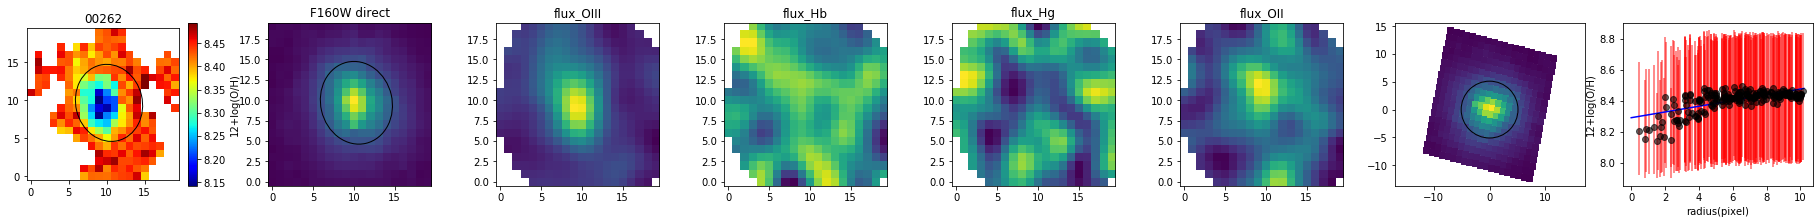

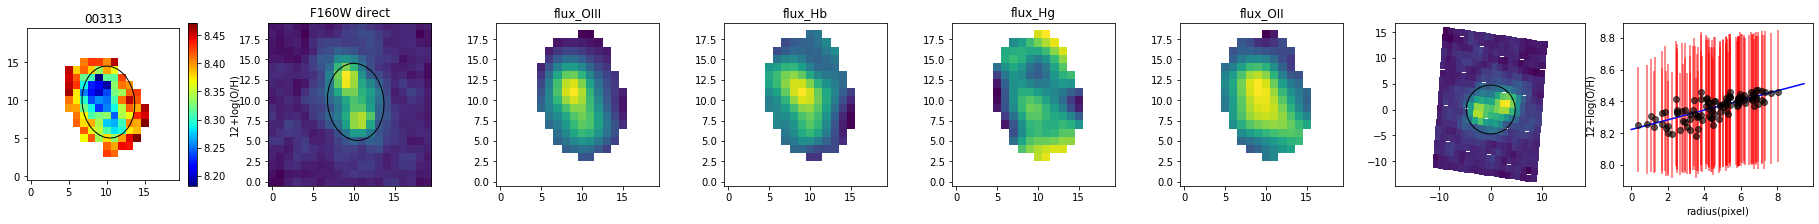

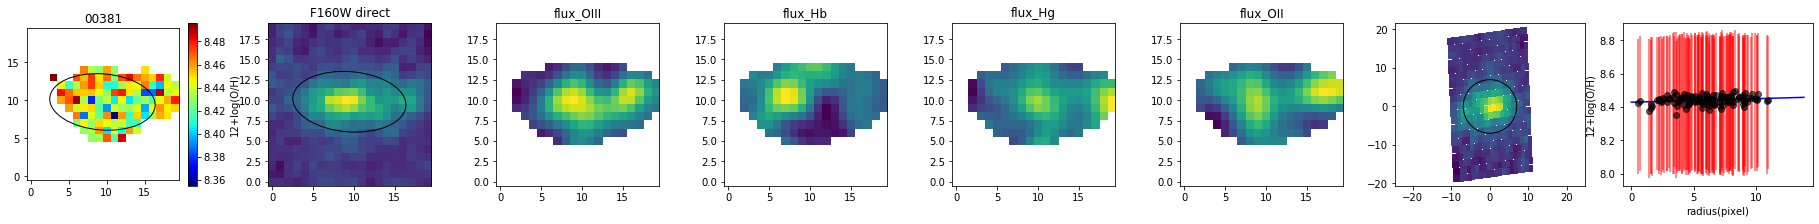

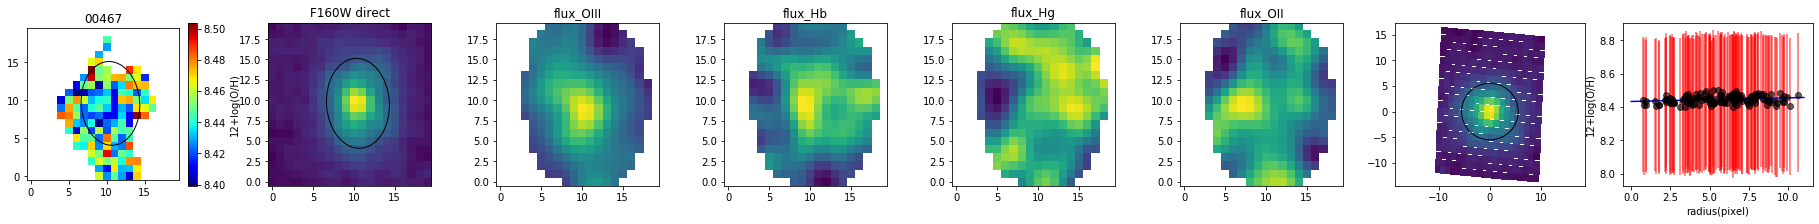

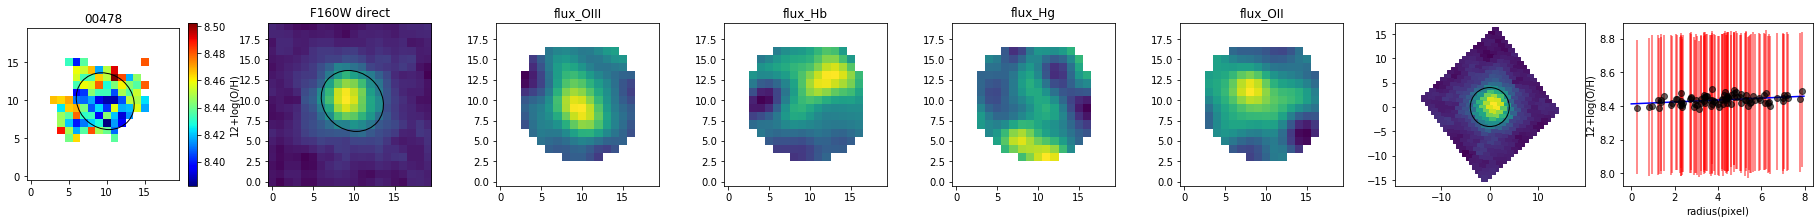

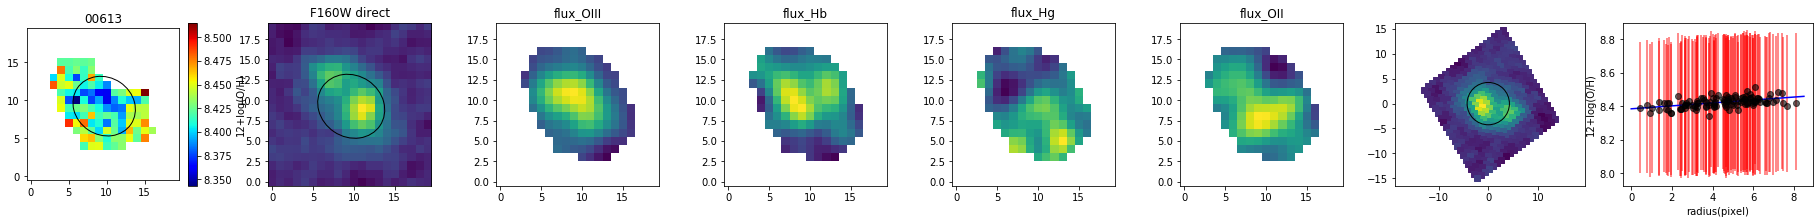

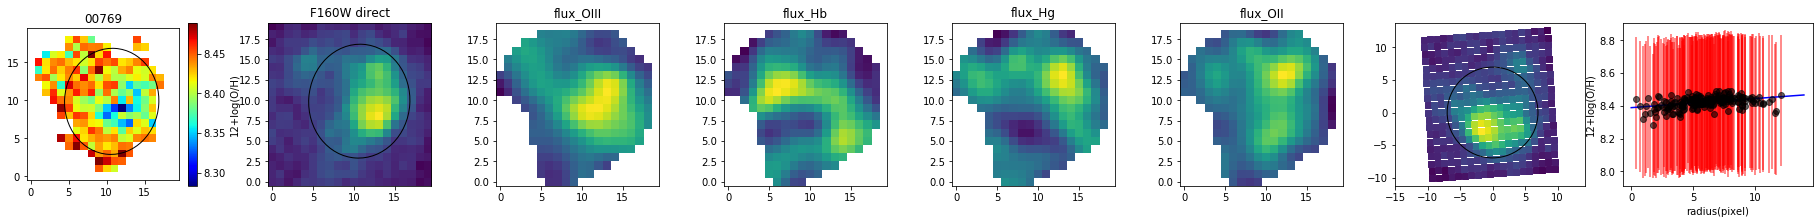

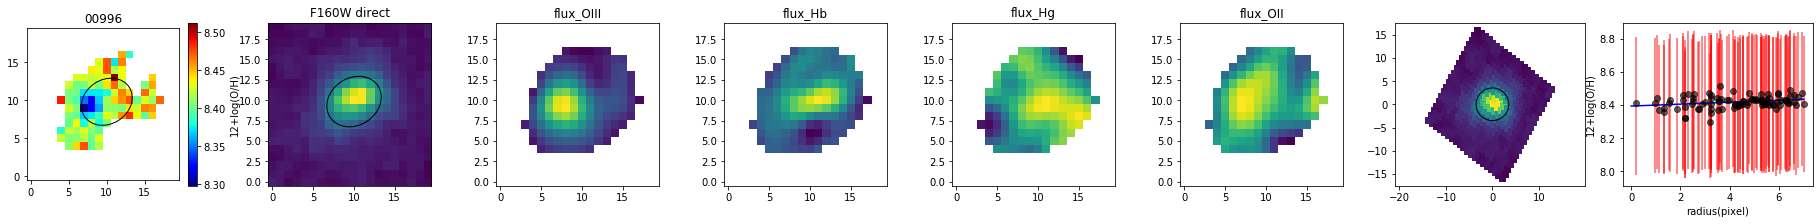

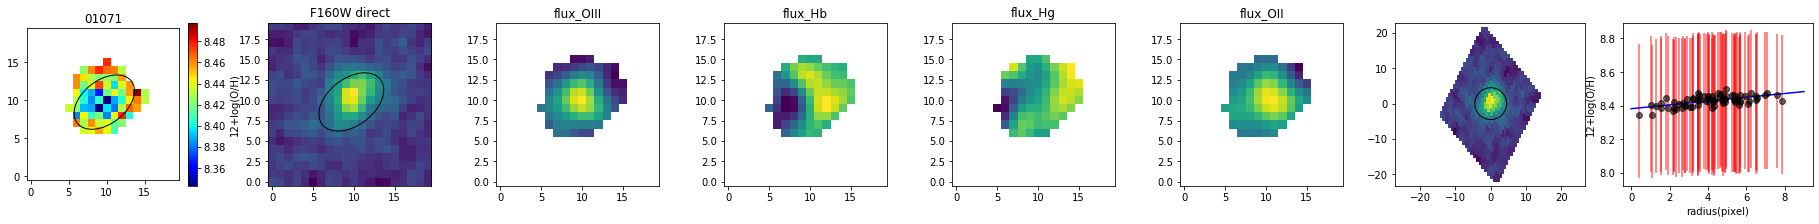

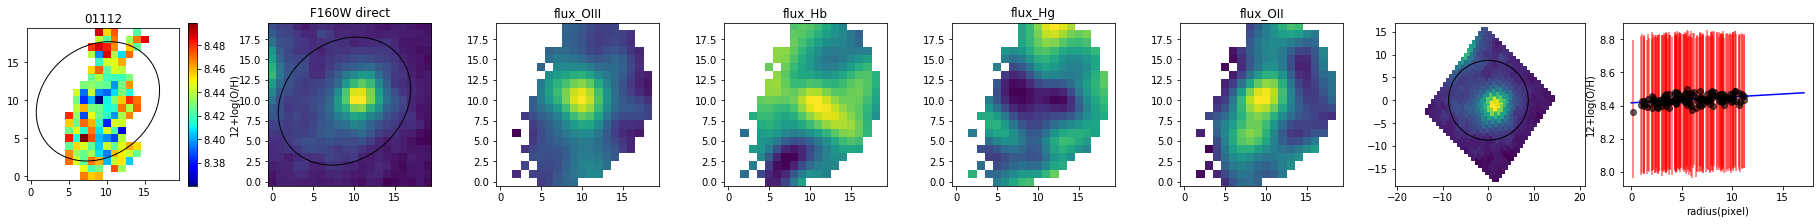

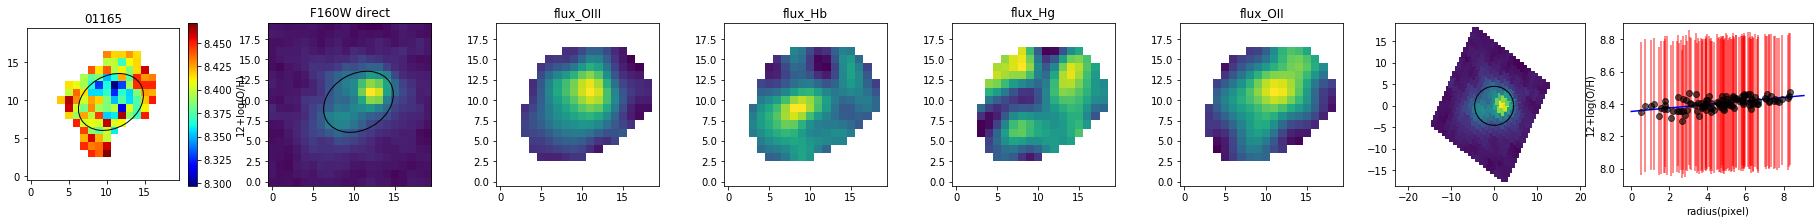

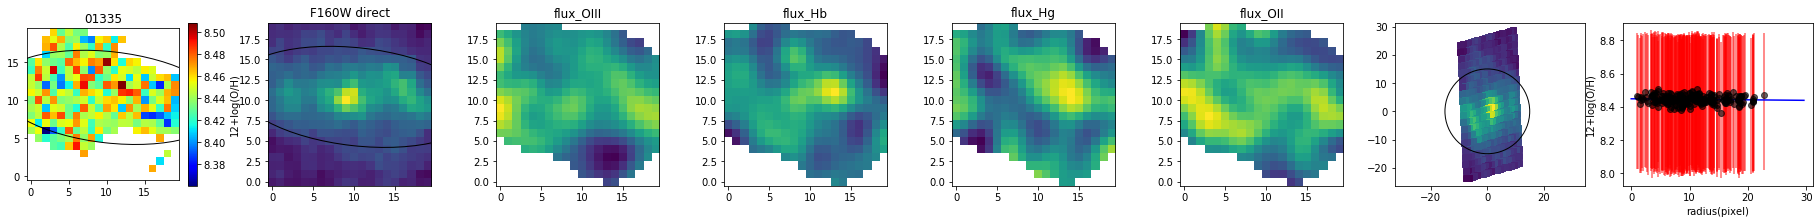

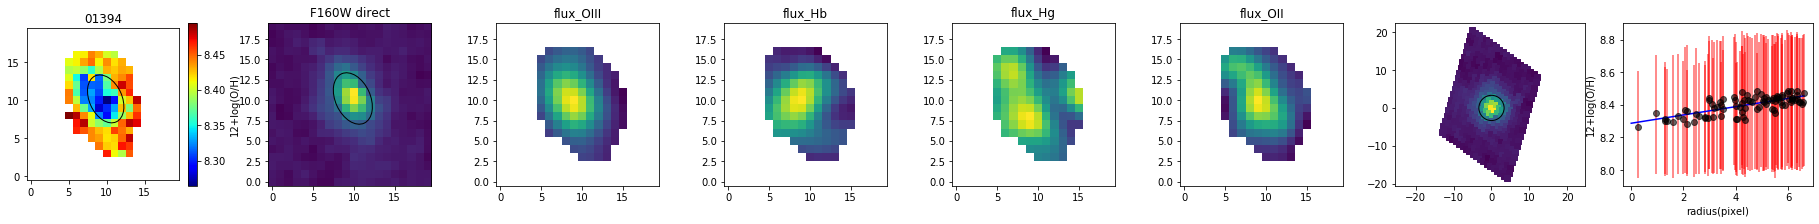

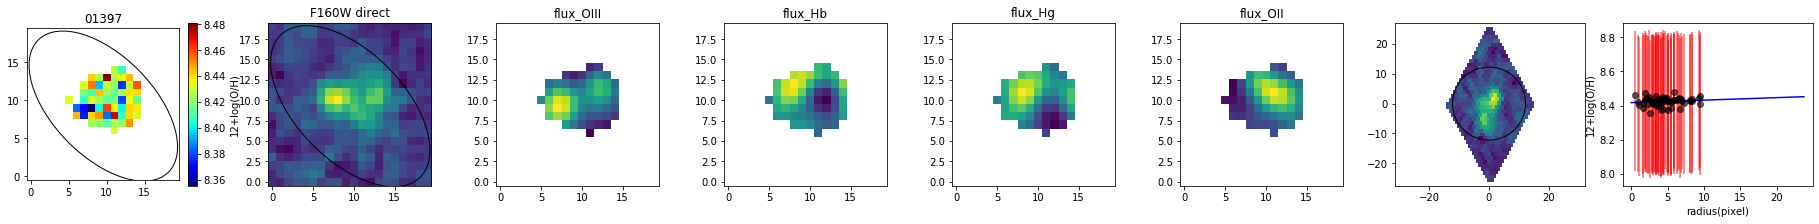

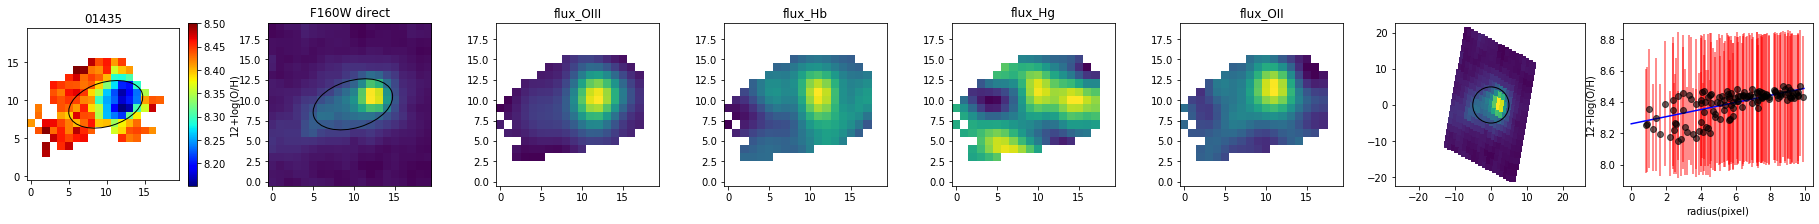

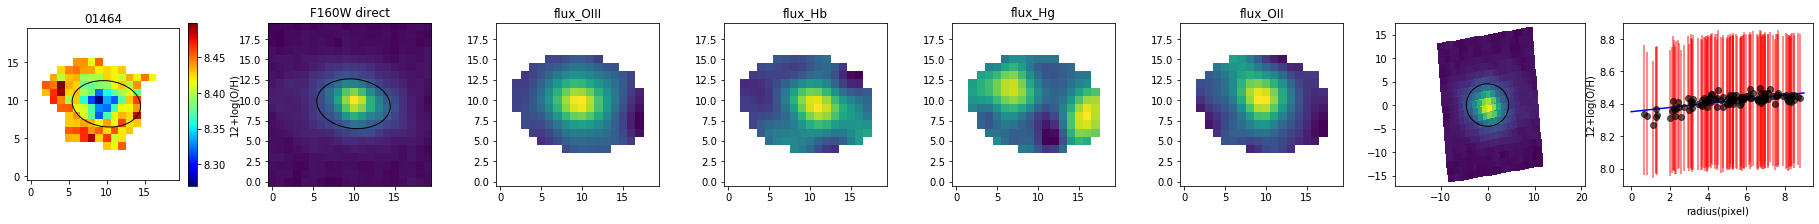

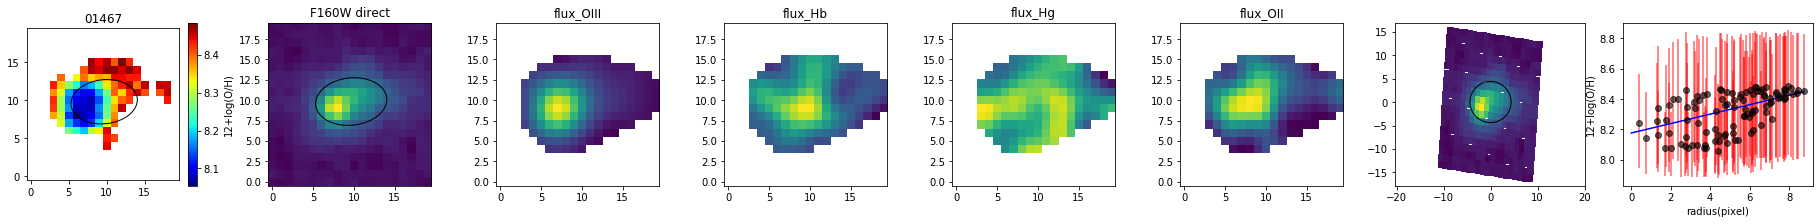

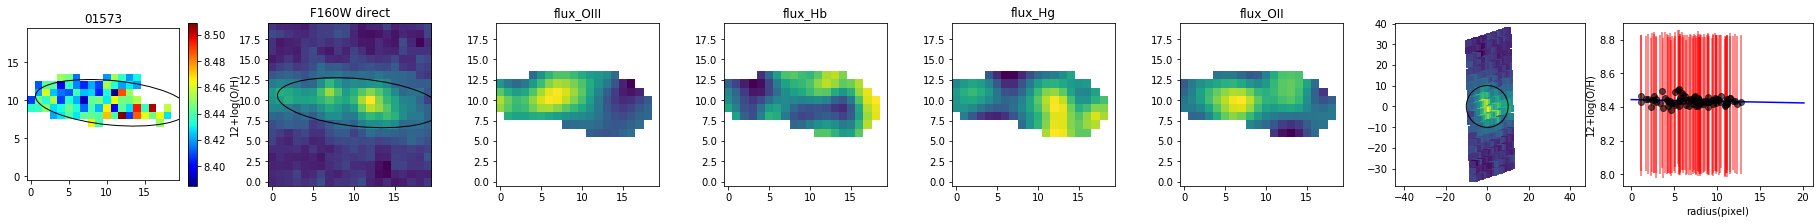

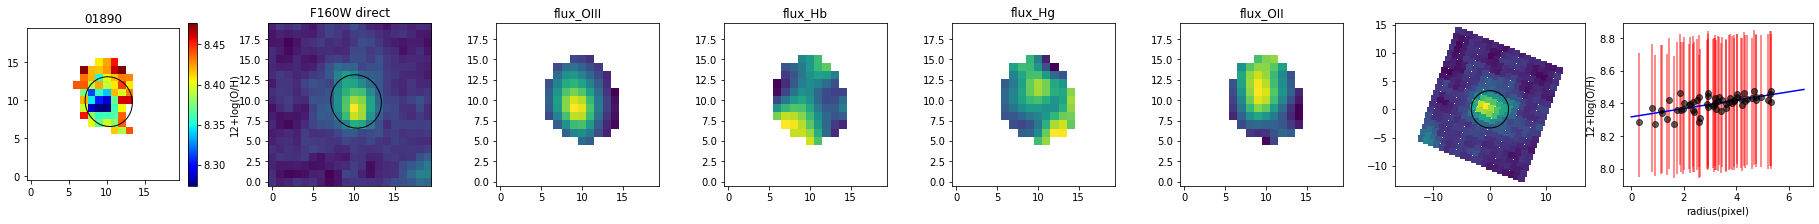

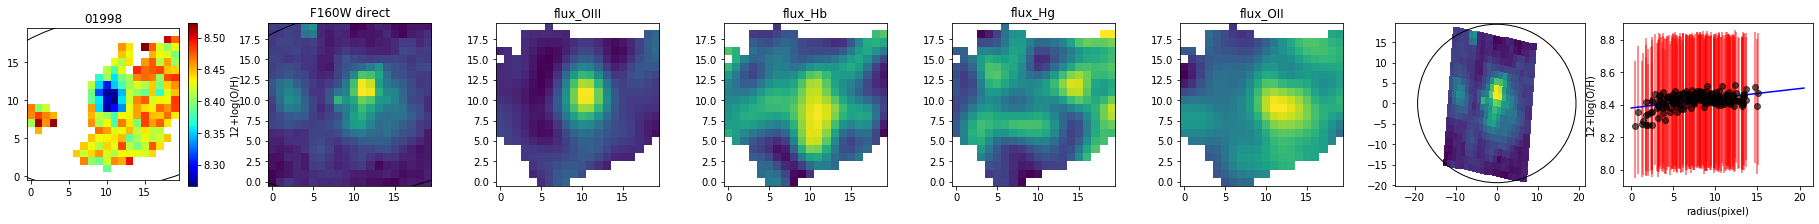

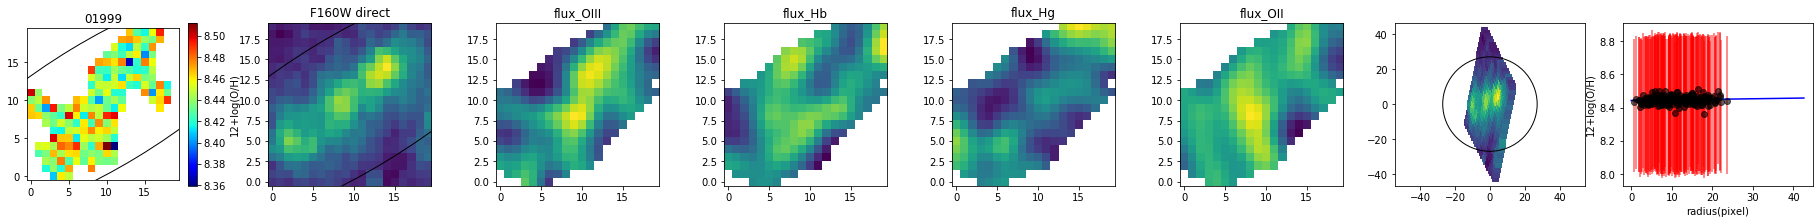

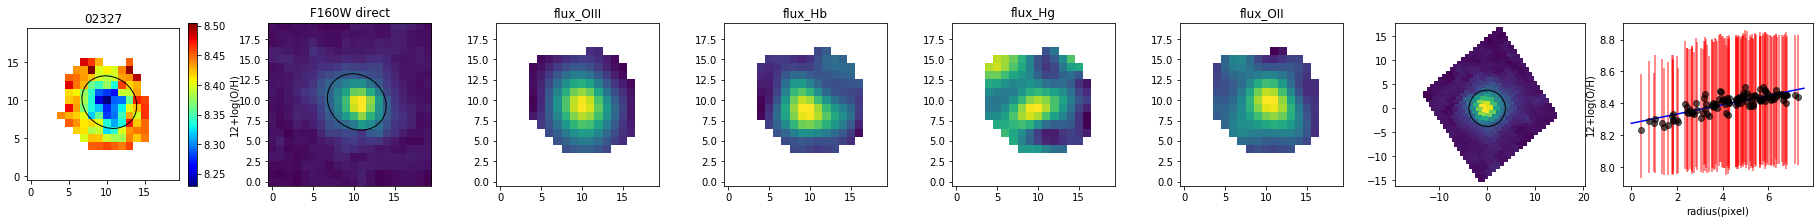

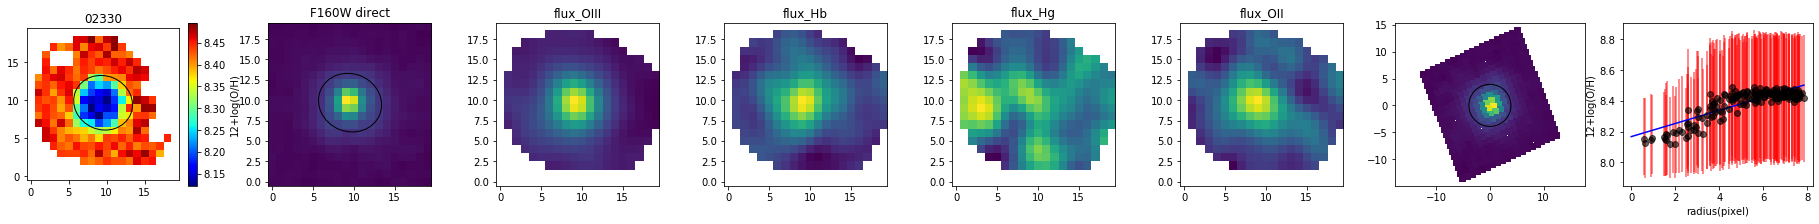

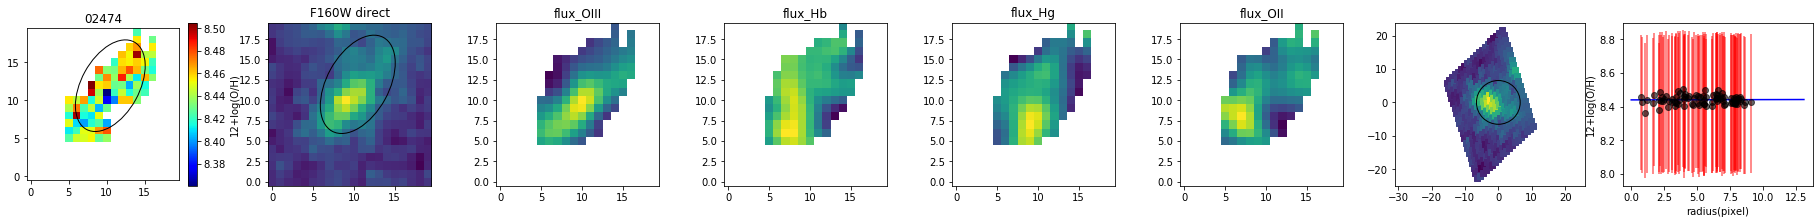

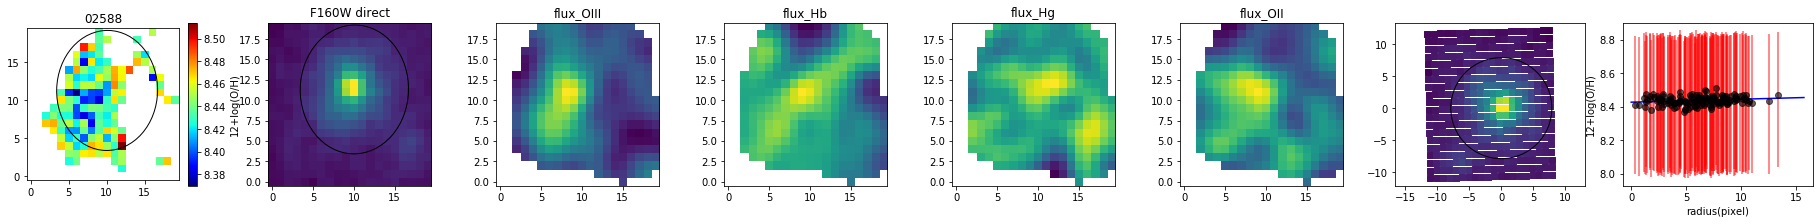

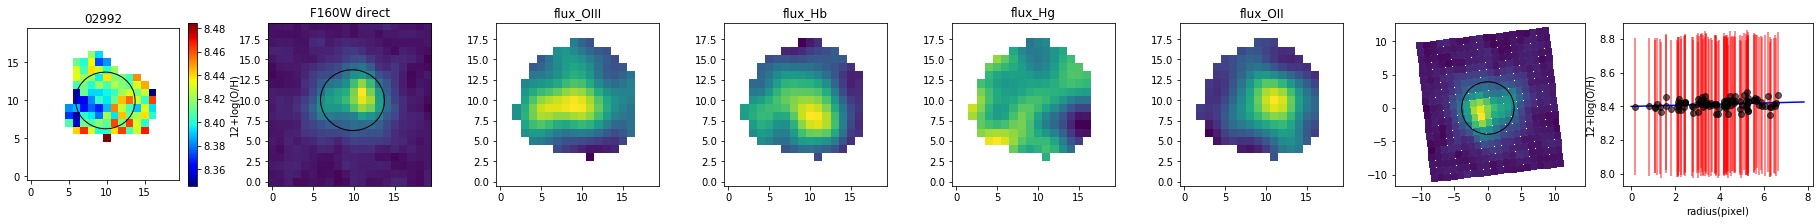

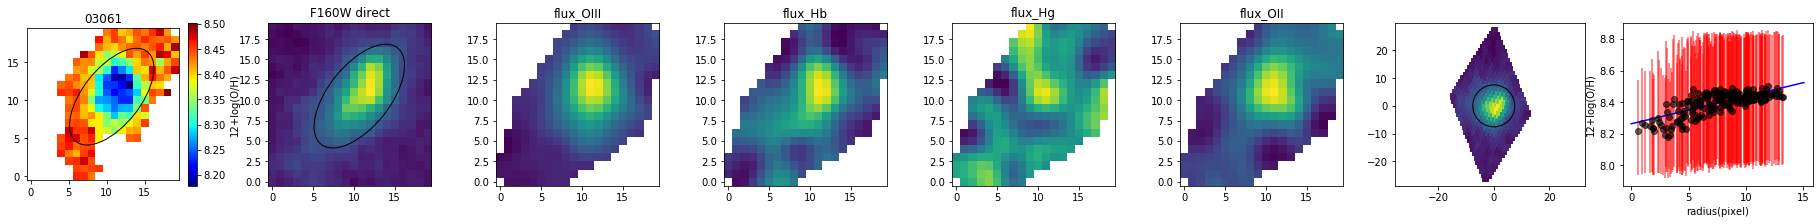

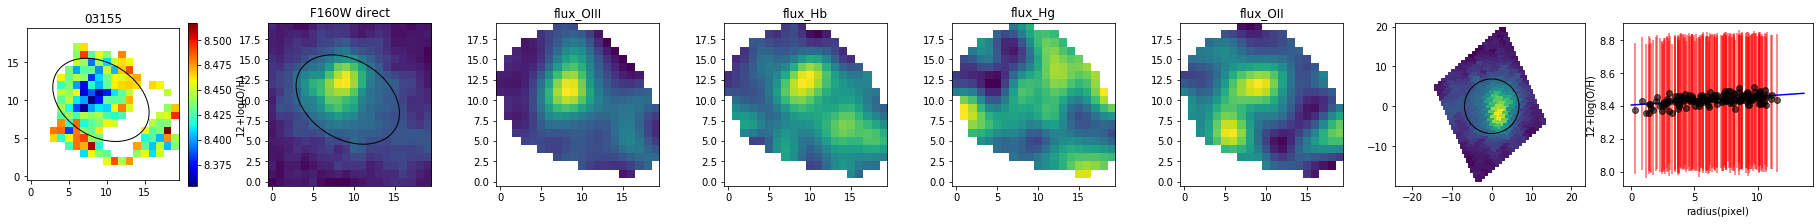

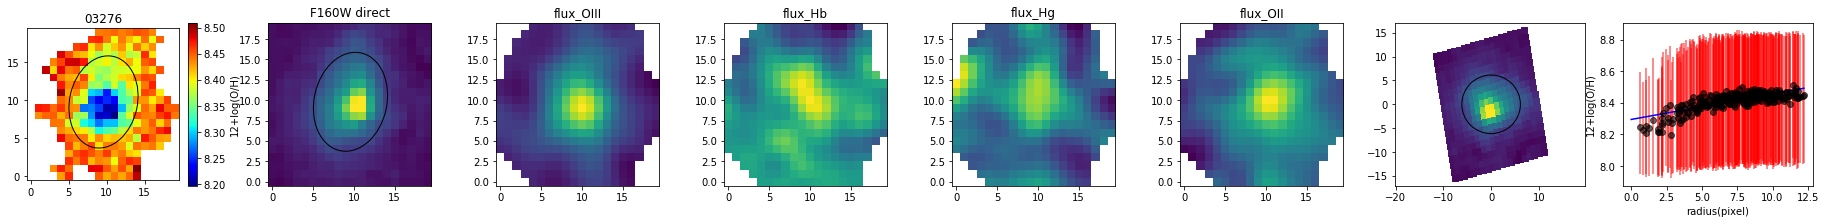

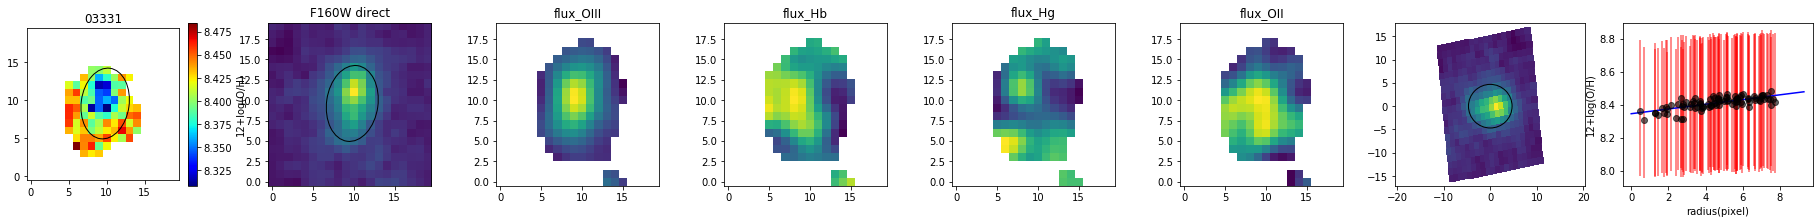

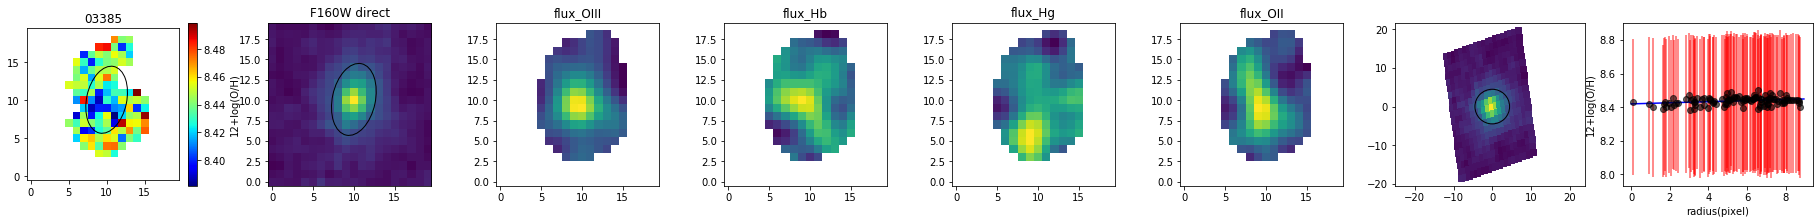

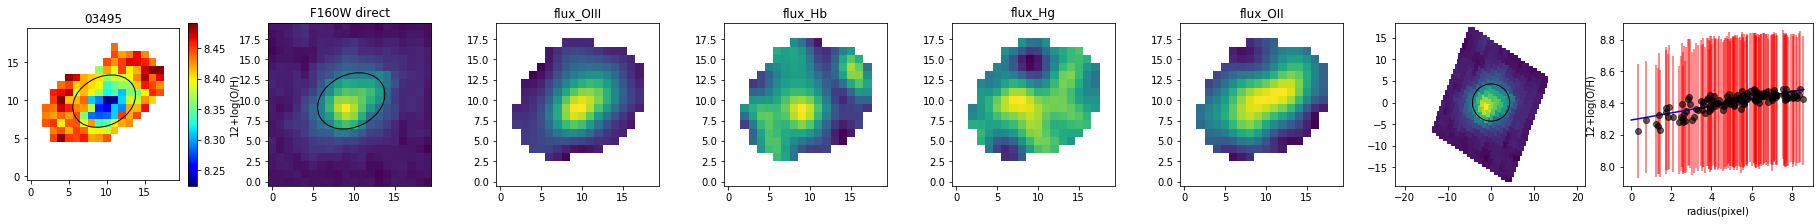

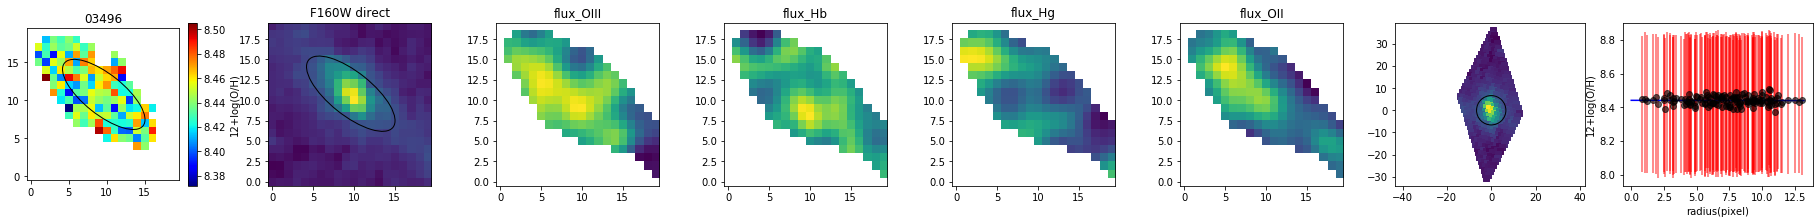

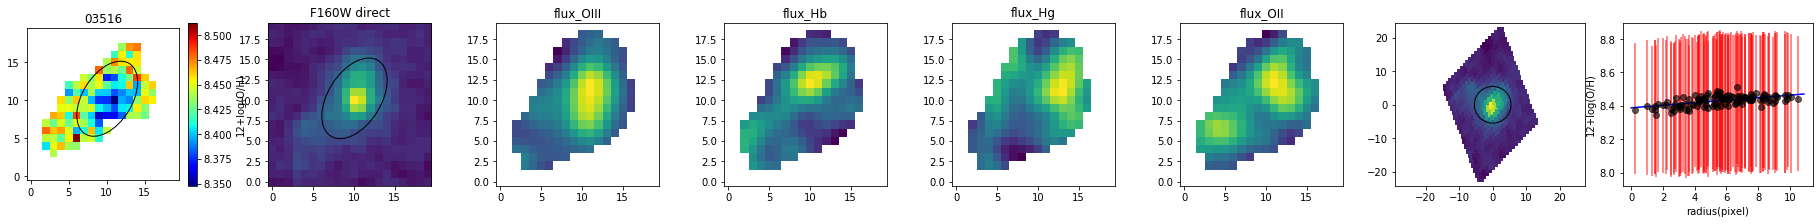

In [12]:
EL = ['flux_OIII','flux_Hb','flux_Hg','flux_OII']

for i in range(len(z_2d)):
    tresh = 0.1


    flux_OIII = EL_data[i]['flux_OIII']
    err_OIII = EL_data[i]['err_OIII']
    flux_OII = EL_data[i]['flux_OII']
    err_OII = EL_data[i]['err_OII']
    z_sn_crop = where((flux_OIII/err_OIII>tresh)&(flux_OII/err_OII>tresh),z_2d[i],np.nan)
    z_low_sn_crop = where((flux_OIII/err_OIII>tresh)&(flux_OII/err_OII>tresh),z_2d_low1[i],np.nan)
    z_up_sn_crop = where((flux_OIII/err_OIII>tresh)&(flux_OII/err_OII>tresh),z_2d_up1[i],np.nan)

    seg = seg_stamp[i].astype(float)
    seg[seg!=seg[w,w]] = nan
    seg/=seg[w,w]
    
    fig,ax = subplots(1,8,figsize=(32,3))

    im1 = ax[0].imshow(z_sn_crop,cmap='jet',origin='lower')
    ax[0].set_title(source_id[i])
    plt.colorbar(im1,ax=ax[0],label='12+log(O/H)')
    
    ax[1].imshow(h_stamp[i],origin='lower')
    ax[1].set_title('F160W direct')
    for j,a in enumerate(ax[2:-2]):
        a.imshow(asarray(EL_data[i][EL[j]]),origin='lower')
        a.set_title(EL[j])
    
    ell1 = Ellipse(xy = (galfit[i][:2]-1), width = 2*galfit[i][2], height = 2*galfit[i][3], angle = 90+galfit[i][4], ec= 'k',fill=False, alpha=1.0)
    ax[1].add_artist(ell1)
    
    x,y = np.meshgrid(linspace(1,20,20),linspace(1,20,20))

    x -= galfit[i][0]
    y -= galfit[i][1]
    coord = np.array([x.flatten(),y.flatten()])

    angle = -(90+galfit[i][4])*2*np.pi/360

    ab = galfit[i][3]/galfit[i][2]
    trans1 = np.array([[np.cos(angle),-np.sin(angle)],[np.sin(angle),np.cos(angle)]])
    trans2 = np.array([[1,0],[0,1/ab]])
    mat_trans = trans2@trans1
    
    x,y=mat_trans@coord
    d = (x**2+y**2)**0.5
    idx = where(d<2*galfit[i][2])

    ax[-2].scatter(x,y,marker='s',c=h_stamp[i].flatten())

    ax[-2].axis('equal')
    
    circ = Circle(xy = (0,0), radius = galfit[i][2], ec= 'k',fill=False, alpha=1.0)
    ax[-2].add_artist(circ)
    ell1 = Ellipse(xy = (galfit[i][:2]-1), width = 2*galfit[i][2], height = 2*galfit[i][3], angle = 90+galfit[i][4], ec= 'k',fill=False, alpha=1.0)
    ax[0].add_artist(ell1)
    
    ax[-1].errorbar(d[idx],z_sn_crop.flatten()[idx],yerr=((z_sn_crop-z_low_sn_crop).flatten()[idx],(z_up_sn_crop-z_sn_crop).flatten()[idx]),
                    fmt='o',ecolor='r',color='k',elinewidth=0,capsize=0,alpha=0.6)
    
    # Fit linear regressing to metallicity versus radius
    x = d[idx]
    y = z_sn_crop.flatten()[idx]
    weight = (z_up_sn_crop-z_low_sn_crop).flatten()[idx]/2
    model = linear_model.LinearRegression()
    x = x.reshape(-1,1)
    y = y.reshape(-1,1)
    model.fit(x[~isnan(weight)],y[~isnan(weight)],weight[~isnan(weight)])
    
    plot(array([0,d[idx].max()]),array([model.intercept_[0],model.intercept_[0]+model.coef_[0][0]*d[idx].max()]),c='blue')
    
    #     ax[-1].scatter(d,z_2d[i].flatten())
    ax[-1].set_xlabel('radius(pixel)')
    ax[-1].set_ylabel('12+log(O/H)')
    
    plt.show()